In [3]:
import numpy as np

def lambda_to_freq(lam):
    freq = 3*10**8/(lam*10**(-9))
    return (freq*10**(-12)) # Returning in terms of THz

def freq_to_lambda(freq):
    lam = 3*10**8/(freq * 10**12)
    return (lam*10**(9))

def THz_to_meV(freq):
    return 6.62 * 6.24 * 0.1 * freq   # meV

def generate_JSA(n, freq_points):

    X, Y = np.meshgrid(freq_points, freq_points)

    x_min = np.min(freq_points)
    x_max = np.max(freq_points)
    y_min = np.min(freq_points)
    y_max = np.max(freq_points)

    x0 = lambda_to_freq(682)
    y0 = lambda_to_freq(692)
    print(f"freq_idler center: {THz_to_meV(x0)}")
    print(f"freq signal center: {THz_to_meV(y0)}")

    # x0, y0 = (x_max + x_min) / 2, (y_max + y_min) / 2  
    sigma_x, sigma_y = 3, 3  
    correlation = 2 # Controls the squeezing along the diagonal

    # Rotation transformation to align Gaussian along off-diagonal
    X_rot = (X - x0) * np.cos(np.pi/4) + (Y - y0) * np.sin(np.pi/4)
    Y_rot = -(X - x0) * np.sin(np.pi/4) + (Y - y0) * np.cos(np.pi/4)

    JSA = np.exp(-((X_rot)**2 / (2 * sigma_x**2) + (Y_rot**2 / (2 * (sigma_y * correlation)**2))))
    JSI = JSA**2 
    JSI = np.abs(JSI)/np.max(JSI)

    return JSI

def generate_JSA_2(n, freq_points):

    X, Y = np.meshgrid(freq_points, freq_points)

    x_min = np.min(freq_points)
    x_max = np.max(freq_points)
    y_min = np.min(freq_points)
    y_max = np.max(freq_points)

    x0 = lambda_to_freq(680)
    y0 = lambda_to_freq(695)
    # x0, y0 = (x_max + x_min) / 2, (y_max + y_min) / 2  
    sigma_x, sigma_y = 3, 3  
    correlation = 2 # Controls the squeezing along the diagonal

    # Rotation transformation to align Gaussian along off-diagonal
    X_rot = (X - x0) * np.cos(np.pi/4) + (Y - y0) * np.sin(np.pi/4)
    Y_rot = -(X - x0) * np.sin(np.pi/4) + (Y - y0) * np.cos(np.pi/4)

    JSA = np.exp(-((X_rot)**2 / (2 * sigma_x**2) + (Y_rot**2 / (2 * (sigma_y * correlation)**2))))
    JSI = JSA**2 
    JSI = np.abs(JSI)/np.max(JSI)

    return JSI

g: 1809.1445255474455
omega_c: 1809.1445255474455
Omega: 1809.1445255474455
freq_idler center: 1817.1026392961878
freq signal center: 1790.8439306358382


NameError: name 'x' is not defined

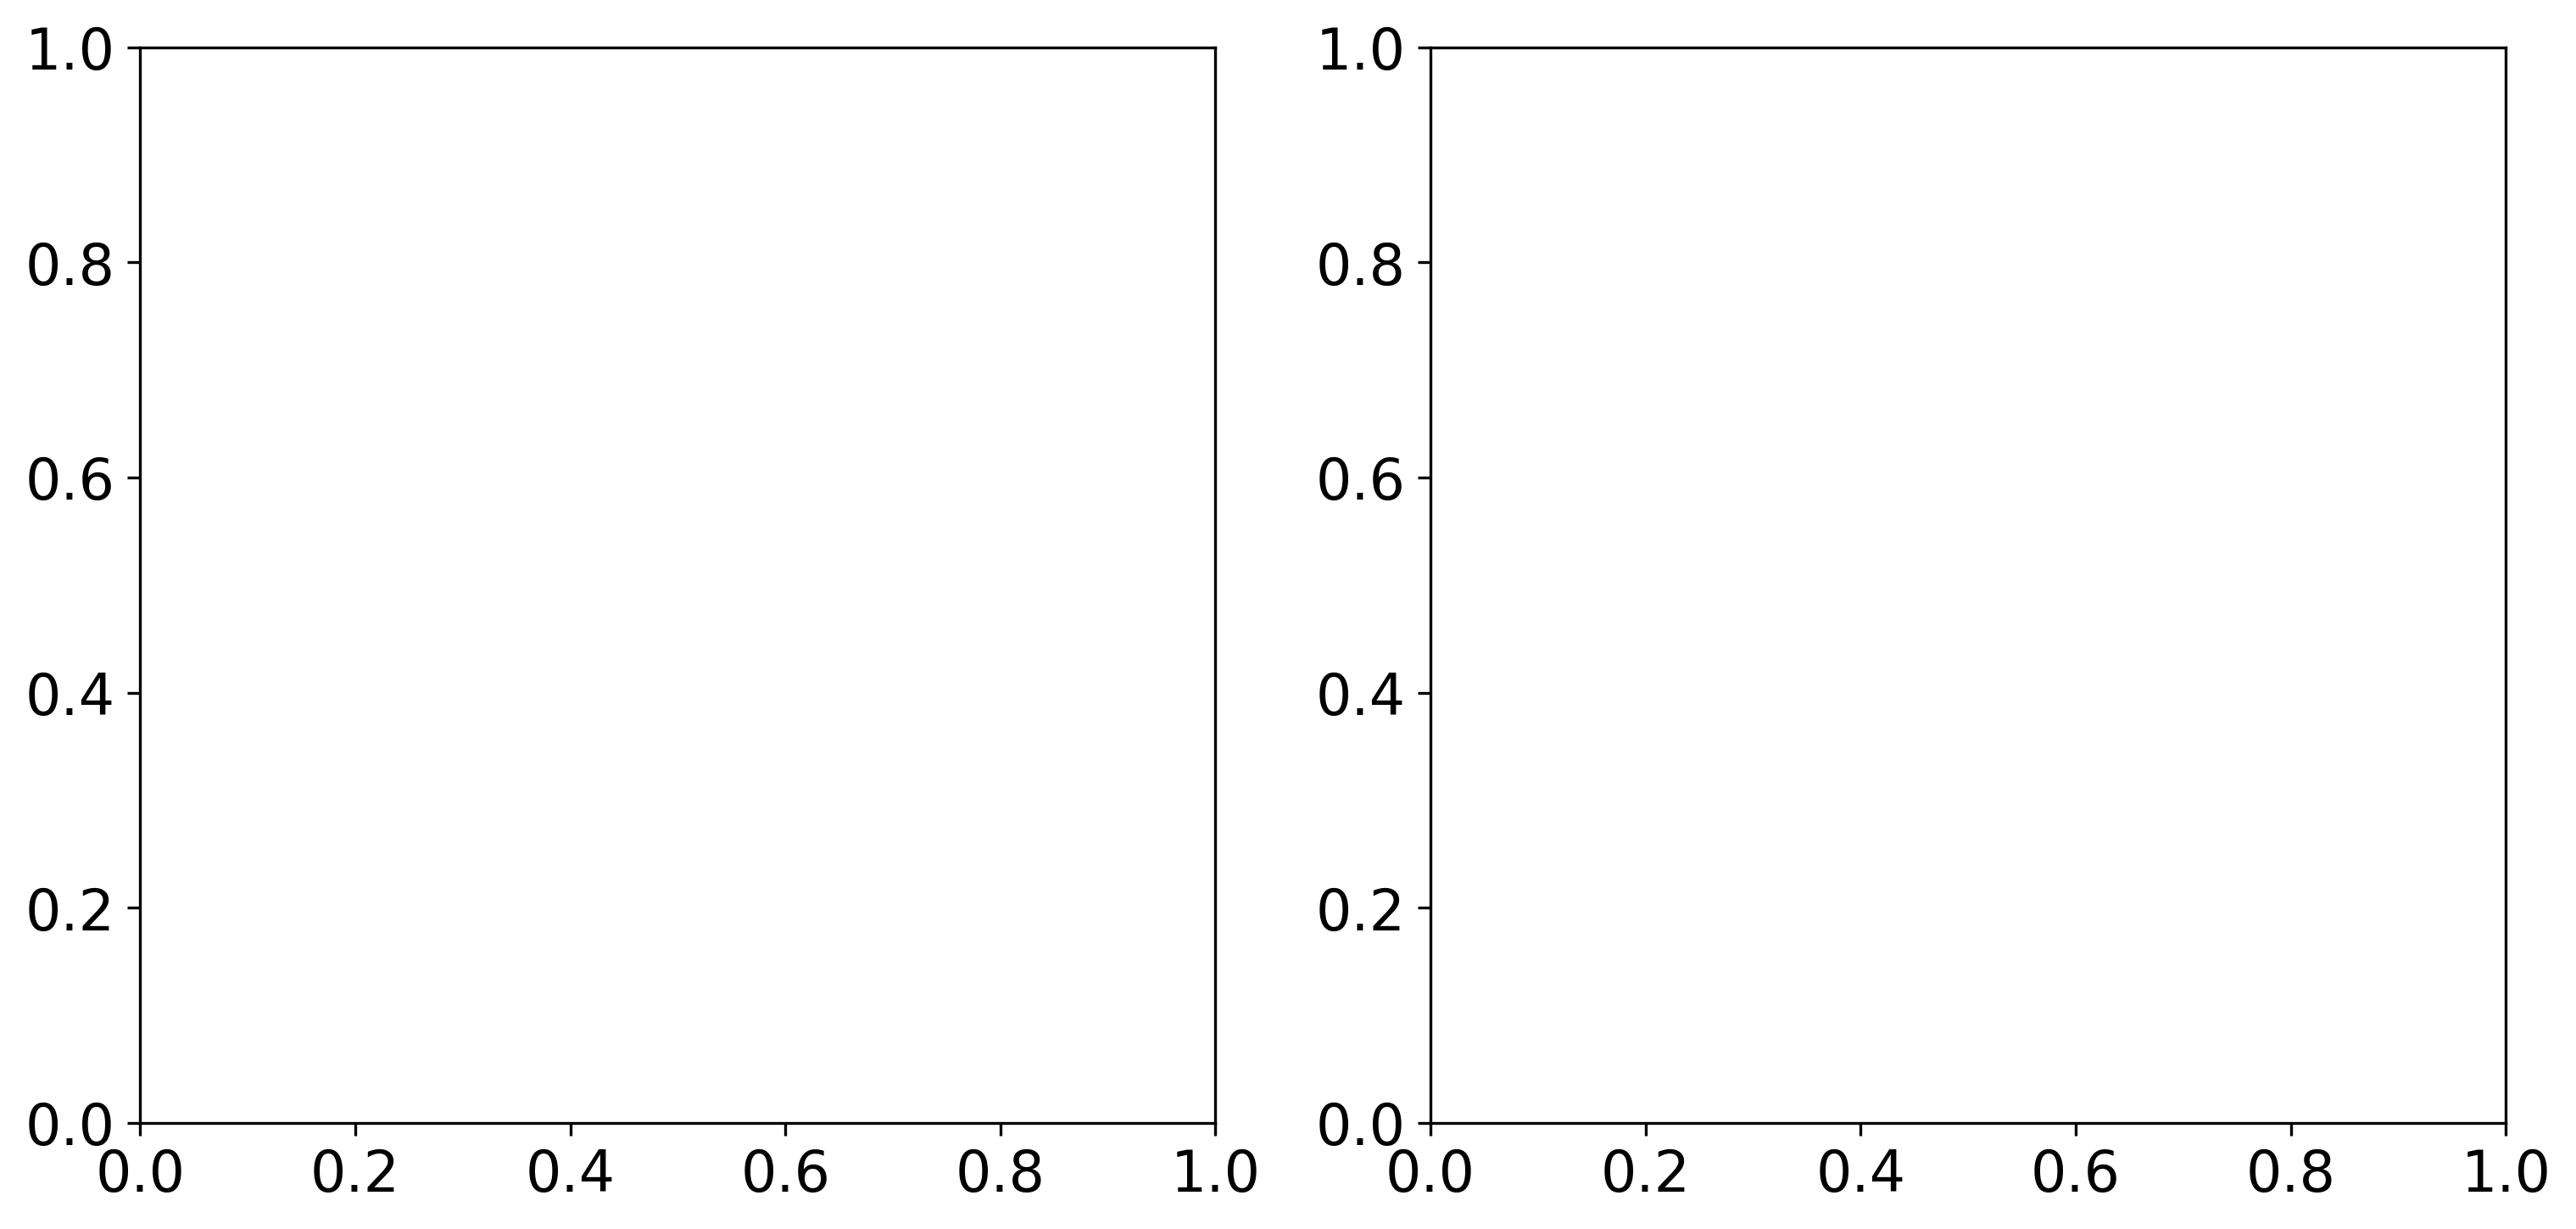

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --------------------------------------------------------------
#  FUNCTION TO GENERATE MATRICES
# --------------------------------------------------------------

def lambda_to_freq(lam):
    freq = 3*10**8/(lam*10**(-9))
    return (freq*10**(-12)) # Returning in terms of THz

def freq_to_lambda(freq):
    lam = 3*10**8/(freq * 10**12)
    return (lam*10**(9))

def THz_to_meV(freq):
    return 6.62 * 6.24 * 0.1 * freq   # meV

def compute_W(g, n, kappa, freq_points, omega_c, Omega):
    W = np.zeros((2*n+2, 2*n+2), dtype=complex)
    np.fill_diagonal(W[:n, :n], -1j*freq_points)
    np.fill_diagonal(W[n:2*n, n:2*n], -1j*freq_points)
    W[2*n, 2*n] = -1j*omega_c - gamma/2
    W[2*n+1, 2*n+1] = -1j*Omega
    W[2*n, :2*n] = -1j*g                            # Bath-Cavity coupling strength
    W[:2*n, 2*n] = -1j*g                            # Bath-Cavity coupling strength
    W[2*n, 2*n+1] = -np.sqrt(kappa)                          # Cavity-spin coupling strength                      
    W[2*n+1, 2*n] = -np.sqrt(kappa)                          # Cavity-spin coupling strength
    return W

def theta_derivative(t, Theta_flat):
    Theta = Theta_flat.reshape(2*n+2, 2*n+2)
    dTheta_dt = W @ Theta + Theta @ W.conj().T
    return dTheta_dt.flatten()

def schmidt_decomposition_entropy(matrix):
    U, S, Vh = np.linalg.svd(matrix)
    p = S**2 / np.sum(S**2)
    entropy = -np.sum(p * np.log(p + 1e-12))  # Small term to avoid log(0)
    return S, entropy

# --------------------------------------------------------------
#  PARAMETERS
# --------------------------------------------------------------

scaling_factor = 1000
FT = np.loadtxt('/home/sameer/Desktop/biphoton/FT.txt', delimiter=',', dtype=np.complex128)

g =  lambda_to_freq(685) / scaling_factor                           # Bath-Cavity coupling strength
omega_c = lambda_to_freq(685) / scaling_factor
Omega = lambda_to_freq(685) / scaling_factor
print(f"g: {THz_to_meV(g*scaling_factor)}")
print(f"omega_c: {THz_to_meV(omega_c*scaling_factor)}")
print(f"Omega: {THz_to_meV(Omega*scaling_factor)}")
gamma = 0
n = 100
freq_min = lambda_to_freq(700) / scaling_factor
freq_max = lambda_to_freq(675) / scaling_factor
freq_points = np.linspace(freq_min, freq_max, n)
kappa = 14000 / scaling_factor                       # Cavity-spin coupling strength      
t_values = np.linspace(1, 10, 10)  
t_span = (t_values[0], t_values[-1])  

# ---------------------------------------------------------------
#   INITIAL CORRELATION MATRIX 
# ---------------------------------------------------------------

JSI = generate_JSA(n, freq_points * scaling_factor)
theta_0 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0, 0.5)
theta_0[n:2*n, :n] = np.sqrt(JSI)
theta_0[:n, n:2*n] = np.sqrt(JSI).T

# ---------------------------------------------------------------
#   SOLVING THE DYNAMICS
# ---------------------------------------------------------------

W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
W_dagger = W.conj().T
S = W.conj().T @ np.linalg.inv(W)  

sol = solve_ivp(theta_derivative, t_span, theta_0.flatten(), t_eval=t_values)
tilde_Theta_in = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
norm_theta = np.linalg.norm(tilde_Theta_in, "fro")
tilde_Theta_in = tilde_Theta_in / norm_theta

A = (tilde_Theta_in @ W.conj().T + W @ tilde_Theta_in + S @ tilde_Theta_in @ S.conj().T @ W + W.conj().T @ S @ tilde_Theta_in @ S.conj().T)
    
Theta_out = theta_0 + A
    
JSI_in = theta_0[n:2*n, :n] ** 2
JSA_out = Theta_out[n:2*n, :n]
JSI_out = np.abs(JSA_out)**2
JSI_out = np.abs(JSI_out)/np.max(np.abs(JSI_out))

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

# ------------------ PLOTTING IN WAVELENGTH SPACE ----------------

fig = plt.figure(figsize=(12, 12), dpi=300)  # Bigger and higher resolution
colornorm = mpl.colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
plt.rcParams.update({'font.size': 16})  # Default font size bump

gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Create the subplots with equal aspect ratio
ax1 = fig.add_subplot(gs[0, 0], box_aspect=1)
ax2 = fig.add_subplot(gs[0, 1], box_aspect=1, sharey=ax1)

# Plot initial JSI (Left figure)
c1 = ax1.contourf(x, y, JSI_in, levels=50, cmap="viridis")
contours1 = ax1.contour(x, y, JSI_in, levels=18, colors='black', linewidths=0.8)
ax1.set_xlabel("Idler Wavelength (nm)", fontsize=22)
ax1.set_ylabel("Signal Wavelength (nm)", fontsize=22)
ax1.set_xticks([675, 680, 685, 690, 695])
ax1.set_ylim(675, 700)
ax1.set_xlim(675, 700)

# Remove the first tick on the y-axis for left plot
ax1.set_yticks(ax1.get_yticks()[1:])  # Skip the first y-tick

# Plot final JSI (Right figure)
c2 = ax2.contourf(x, y, JSI_out, levels=50, cmap="viridis")
contours2 = ax2.contour(x, y, JSI_out, levels=18, colors='black', linewidths=0.8)
ax2.set_xlabel("Idler Wavelength (nm)", fontsize=22)
ax2.set_xlim(675, 700)
ax2.set_ylim(675, 700)

# Remove y-axis label and ticks for the right plot
ax2.set_ylabel('')
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Improve tick sizes for both plots
ax1.tick_params(labelbottom=True, labelsize=18)
ax2.tick_params(labelbottom=True, labelleft=False, labelsize=18)

# Colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=colornorm)
sm.set_array([])

cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.38])  # Adjust the position of colorbar
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Normalized JSI", fontsize=22)
cbar.ax.tick_params(labelsize=18)

# Layout tweaks to improve spacing between the plots
plt.subplots_adjust(hspace=0, wspace=0.08)

# Save the plot with better DPI and layout
plt.savefig("squeezed_gaussian.png", dpi=300, bbox_inches='tight')


In [47]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --------------------------------------------------------------
#  FUNCTION TO GENERATE MATRICES
# --------------------------------------------------------------

def lambda_to_freq(lam):
    return 3e8 / (lam * 1e-9) * 1e-12  # Convert to THz

def freq_to_lambda(freq):
    return 3e8 / (freq * 1e12) * 1e9  # Convert to nm

def schmidt_decomposition_entropy(matrix):
    U, S, Vh = np.linalg.svd(matrix)
    p = S**2 / np.sum(S**2)
    entropy = -np.sum(p * np.log(p + 1e-12))  # Small term to avoid log(0)
    return entropy

def compute_W(g, n, kappa, freq_points, omega_c, Omega):
    W = np.zeros((2*n+2, 2*n+2), dtype=complex)
    np.fill_diagonal(W[:n, :n], -1j*freq_points)
    np.fill_diagonal(W[n:2*n, n:2*n], -1j*freq_points)
    W[2*n, 2*n] = -1j*omega_c
    W[2*n+1, 2*n+1] = -1j*Omega
    W[2*n, :2*n] = -1j*g  # Bath-Cavity coupling
    W[:2*n, 2*n] = -1j*g
    W[2*n, 2*n+1] = -np.sqrt(kappa)  # Cavity-spin coupling
    W[2*n+1, 2*n] = -np.sqrt(kappa)
    return W

def theta_derivative(t, Theta_flat, W):
    Theta = Theta_flat.reshape(2*n+2, 2*n+2)
    dTheta_dt = W @ Theta + Theta @ W.conj().T
    return dTheta_dt.flatten()

# --------------------------------------------------------------
#  PARAMETERS
# --------------------------------------------------------------

scaling_factor = 1000

g =  lambda_to_freq(685) / scaling_factor                           # Bath-Cavity coupling strength
omega_c = lambda_to_freq(685) / scaling_factor
Omega = lambda_to_freq(685) / scaling_factor
gamma = 0
n = 100
freq_min = lambda_to_freq(700) / scaling_factor
freq_max = lambda_to_freq(675) / scaling_factor
freq_points = np.linspace(freq_min, freq_max, n)
kappa = 10000 / scaling_factor                       # Cavity-spin coupling strength      
t_values = np.linspace(1, 10, 10)  
t_span = (t_values[0], t_values[-1])  

# ---------------------------------------------------------------
#   INITIAL CORRELATION MATRIX 
# ---------------------------------------------------------------

JSI = generate_JSA(n, freq_points * scaling_factor)
theta_0 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0, 0.5)
theta_0[n:2*n, :n] = np.sqrt(JSI)
theta_0[:n, n:2*n] = np.sqrt(JSI).T

JSI_2 = generate_JSA_2(n, freq_points * scaling_factor)
theta_0_2 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0_2, 0.5)
theta_0_2[n:2*n, :n] = np.sqrt(JSI_2)
theta_0_2[:n, n:2*n] = np.sqrt(JSI_2).T

# --------------------------------------------------------------
#  COMPUTE ENTROPY FOR VARYING kappa
# --------------------------------------------------------------

kappa_values = np.linspace(0, 30000, 20) / scaling_factor
entropies = []
entropies_2 = []

for kappa in kappa_values:
    W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
    sol = solve_ivp(theta_derivative, t_span, theta_0.flatten(), args=(W,), dense_output=True)
    sol_y_interp = np.array([sol.sol(t) for t in t_values]).T

    print(sol.y.shape)
    
    # Compute Theta_out
    tilde_Theta_in = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
    norm_theta = np.linalg.norm(tilde_Theta_in, "fro")
    tilde_Theta_in /= norm_theta
    
    S = W.conj().T @ np.linalg.inv(W)
    A = (tilde_Theta_in @ W.conj().T + W @ tilde_Theta_in + S @ tilde_Theta_in @ S.conj().T @ W + 
         W.conj().T @ S @ tilde_Theta_in @ S.conj().T)
    
    Theta_out = theta_0 + A
    JSA_out = Theta_out[n:2*n, :n]

    # Compute Schmidt entropy
    entropy = schmidt_decomposition_entropy(JSA_out)
    entropies.append(entropy)


    W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
    sol = solve_ivp(theta_derivative, t_span, theta_0_2.flatten(), args=(W,), dense_output=True)
    sol_y_interp = np.array([sol.sol(t) for t in t_values]).T

    print(sol.y.shape)
    
    # Compute Theta_out
    tilde_Theta_in_2 = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
    norm_theta_2 = np.linalg.norm(tilde_Theta_in_2, "fro")
    tilde_Theta_in_2 /= norm_theta_2
    
    S = W.conj().T @ np.linalg.inv(W)
    A = (tilde_Theta_in_2 @ W.conj().T + W @ tilde_Theta_in_2 + S @ tilde_Theta_in_2 @ S.conj().T @ W + 
         W.conj().T @ S @ tilde_Theta_in_2 @ S.conj().T)
    
    Theta_out_2 = theta_0_2 + A
    JSA_out_2 = Theta_out_2[n:2*n, :n]

    # Compute Schmidt entropy
    entropy_2 = schmidt_decomposition_entropy(JSA_out_2)
    entropies_2.append(entropy_2)

(40804, 120)
(40804, 125)
(40804, 120)
(40804, 124)
(40804, 119)
(40804, 122)
(40804, 117)
(40804, 121)
(40804, 117)
(40804, 118)
(40804, 114)
(40804, 115)
(40804, 112)
(40804, 113)
(40804, 109)
(40804, 112)
(40804, 106)
(40804, 110)
(40804, 102)
(40804, 107)
(40804, 98)
(40804, 103)
(40804, 95)
(40804, 99)
(40804, 93)
(40804, 95)
(40804, 90)
(40804, 91)
(40804, 86)
(40804, 86)
(40804, 83)
(40804, 83)
(40804, 80)
(40804, 80)
(40804, 74)
(40804, 73)
(40804, 70)
(40804, 70)
(40804, 65)
(40804, 65)


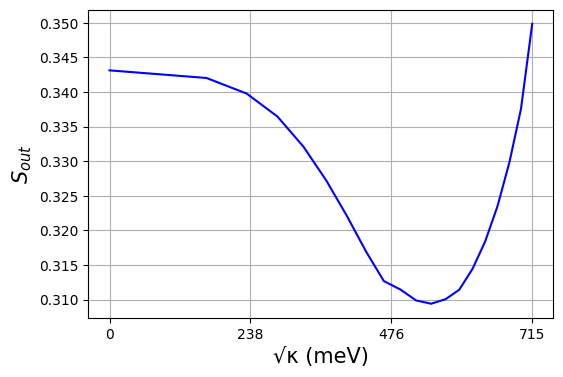

In [51]:
# --------------------------------
#   PLOTTING ENTROPY vs. KAPPA
# --------------------------------

def THz_to_meV(freq):
    return 6.62 * 6.24 * 0.1 * freq   # meV

plt.figure(figsize=(6, 4))
kappa_meV = THz_to_meV(np.sqrt(kappa_values * scaling_factor))
plt.plot(kappa_meV, entropies, linestyle='-', color='b')
# plt.plot(kappa_meV, entropies_2, linestyle='-', color='r')

num_ticks = 4
kappa_ticks = np.linspace(kappa_meV[0], kappa_meV[-1], num_ticks)

# Set the ticks directly from kappa_values
plt.xticks(kappa_ticks, [f'{int(k)}' for k in kappa_ticks], fontsize=10)

plt.xlabel(f"√κ (meV)", fontsize=15)
plt.ylabel('$S_{out}$', fontsize=15)
plt.grid()
plt.savefig("entropy_gaussian_squeezed.png")

Observations:

Entropy curve remains the same regardless of where I initialize it and in what shape I do. It first decreases and then increases. Its the same for a gaussian initial state or an experimental input. If the gaussian is centered elsewhere, only the minima point is shifted to a different kappa. Gaussian minima is further in $\sqrt{\kappa}$ than for expt. data. I guess the explanation behind this is simply the fact that some excitations probably remain in the matrial dof. This is when the output residual photons have lost some coherence. Then probably some stationary state happens and excitations no longer keep sinking into the material but also exit. So there is a reemergence of correlations?

JSI_out doesn't change much for gaussian. This may be coz for symmetric entanglement amplitudes, the structure does not change and that for asymmetric entanglement ampltidues, it changes.

Mutual Information calculation (might need to step back and do partial trace?)

In [53]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --------------------------------------------------------------
#  FUNCTION TO GENERATE MATRICES
# --------------------------------------------------------------

def lambda_to_freq(lam):
    return 3e8 / (lam * 1e-9) * 1e-12  # Convert to THz

def schmidt_decomposition_entropy(matrix):
    U, S, Vh = np.linalg.svd(matrix)
    p = S**2 / np.sum(S**2)
    entropy = -np.sum(p * np.log(p + 1e-12))  # Small term to avoid log(0)
    return entropy

def von_neumann_entropy(rho):
    eigenvalues = np.linalg.eigvalsh(rho)  # Get eigenvalues
    eigenvalues = eigenvalues[eigenvalues > 1e-12]  # Avoid log(0) issues
    return -np.sum(eigenvalues * np.log(eigenvalues))

def compute_W(g, n, kappa, freq_points, omega_c, Omega):
    W = np.zeros((2*n+2, 2*n+2), dtype=complex)
    np.fill_diagonal(W[:n, :n], -1j*freq_points)
    np.fill_diagonal(W[n:2*n, n:2*n], -1j*freq_points)
    W[2*n, 2*n] = -1j*omega_c
    W[2*n+1, 2*n+1] = -1j*Omega
    W[2*n, :2*n] = -1j*g  # Bath-Cavity coupling
    W[:2*n, 2*n] = -1j*g
    W[2*n, 2*n+1] = -np.sqrt(kappa)  # Cavity-spin coupling
    W[2*n+1, 2*n] = -np.sqrt(kappa)
    return W

def theta_derivative(t, Theta_flat, W):
    Theta = Theta_flat.reshape(2*n+2, 2*n+2)
    dTheta_dt = W @ Theta + Theta @ W.conj().T
    return dTheta_dt.flatten()

# --------------------------------------------------------------
#  PARAMETERS
# --------------------------------------------------------------

scaling_factor = 1000

g =  lambda_to_freq(685) / scaling_factor                           # Bath-Cavity coupling strength
omega_c = lambda_to_freq(685) / scaling_factor
Omega = lambda_to_freq(685) / scaling_factor
n = 100
freq_min = lambda_to_freq(700) / scaling_factor
freq_max = lambda_to_freq(675) / scaling_factor
freq_points = np.linspace(freq_min, freq_max, n)
kappa_values = np.linspace(0, 15000, 20) / scaling_factor
t_values = np.linspace(1, 10, 10)  
t_span = (t_values[0], t_values[-1])  

# ---------------------------------------------------------------
#   INITIAL CORRELATION MATRIX 
# ---------------------------------------------------------------

JSI = generate_JSA(n, freq_points * scaling_factor)
theta_0 = np.zeros((2*n+2, 2*n+2), dtype=complex)
np.fill_diagonal(theta_0, 0.5)
theta_0[n:2*n, :n] = np.sqrt(JSI)
theta_0[:n, n:2*n] = np.sqrt(JSI).T

# --------------------------------------------------------------
#  COMPUTE ENTROPY AND MUTUAL INFORMATION
# --------------------------------------------------------------

entropies = []
mutual_infos = []

for kappa in kappa_values:
    W = compute_W(g, n, kappa, freq_points, omega_c, Omega)
    sol = solve_ivp(theta_derivative, t_span, theta_0.flatten(), args=(W,), dense_output=True)
    
    # Compute integrated Theta_out
    tilde_Theta_in = sum(sol.y[:, i].reshape(2*n+2, 2*n+2) for i in range(len(t_values)))
    norm_theta = np.linalg.norm(tilde_Theta_in, "fro")
    tilde_Theta_in /= norm_theta
    
    S = W.conj().T @ np.linalg.inv(W)
    A = (tilde_Theta_in @ W.conj().T + W @ tilde_Theta_in + S @ tilde_Theta_in @ S.conj().T @ W + 
         W.conj().T @ S @ tilde_Theta_in @ S.conj().T)
    
    Theta_out = theta_0 + A
    JSA_out = Theta_out[n:2*n, :n]

    # Compute Schmidt entropy
    entropy = schmidt_decomposition_entropy(JSA_out)
    entropies.append(entropy)

    # Compute Mutual Information
    rho_AB = JSA_out  # Full system density matrix
    rho_A = np.trace(rho_AB.reshape(n, 2, n, 2), axis1=1, axis2=3).reshape(n, n)  # Partial trace over one subsystem
    rho_B = np.trace(rho_AB.reshape(n, 2, n, 2), axis1=0, axis2=2).reshape(n, n)

    S_AB = von_neumann_entropy(rho_AB)
    S_A = von_neumann_entropy(rho_A)
    S_B = von_neumann_entropy(rho_B)

    mutual_info = S_A + S_B - S_AB
    mutual_infos.append(mutual_info)

# --------------------------------------------------------------
#  PLOT RESULTS
# --------------------------------------------------------------

plt.figure(figsize=(8,5))
plt.plot(kappa_values * scaling_factor, entropies, label="Schmidt Entropy", marker="o")
plt.plot(kappa_values * scaling_factor, mutual_infos, label="Mutual Information", marker="s")
plt.xlabel("Cavity-Spin Coupling $\\kappa$")
plt.ylabel("Entropy / Mutual Information")
plt.legend()
plt.title("Schmidt Entropy & Mutual Information vs $\kappa$")
plt.grid()
plt.show()


<>:116: SyntaxWarning: invalid escape sequence '\k'
<>:116: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_384031/3902069860.py:116: SyntaxWarning: invalid escape sequence '\k'
  plt.title("Schmidt Entropy & Mutual Information vs $\kappa$")
/tmp/ipykernel_384031/3902069860.py:116: SyntaxWarning: invalid escape sequence '\k'
  plt.title("Schmidt Entropy & Mutual Information vs $\kappa$")


ValueError: cannot reshape array of size 10000 into shape (100,2,100,2)